# Train the model

Preferably, train using the train.py script.
But you can also do that using this notebook.

## Set-up

In [1]:
%load_ext autoreload
%autoreload 2
%cd ../

/home/projects/schneidmann/royu/thesis/unsup_neur


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from utils.modules import Modules
from run_before_script import run
run()

## Model configuration file

Each model is defined by its module and name, assuming that there exists a configuration file \<module\>\\config\\\<model\>.json

In [3]:
# Change the module and model
MODULE = Modules.VISION
model_name = "vit_lite_2_4_N10_d0.05_seed1"

In [4]:
dct = MODULE.load_json(model_name, config=True)

Each configuration file should include model_kwargs (and inside it, module specific kwargs), dataset, loss and loss_kwargs

In [5]:
import json
print(json.dumps(dct, indent=4))

{
    "model_kwargs": {
        "l2": 0,
        "encoder_per_path": true,
        "patch_encoder_after_split": true,
        "pathways_kwargs": {
            "n": 10,
            "d": 0.05,
            "fixed": true,
            "seed": 1
        },
        "projection_dim": 256,
        "image_size": 32,
        "patch_size": 4,
        "encoder_kwargs": {
            "ln": true,
            "layers": 2,
            "only_classtoken": true,
            "block_kwargs": {
                "projection_dim": 256,
                "divide_dim_by_head": true,
                "num_heads": 4
            },
            "out_block_kwargs": {
                "dropout_rate": 0,
                "mlp_head_units": [],
                "output_dim": 0
            }
        }
    },
    "dataset": "Cifar10",
    "loss_kwargs": {},
    "loss": "CLoSeRLoss",
    "ensemble_classification": true
}


If you want for example to create a new model with a different name with a similar configuration, for example with a different seed, you can either:
* use the train.py script with the arguments -j \<original model\> --seed \<new seed\>
* Or you can use the following script:

In [6]:
# new_dct = deepcopy(dct)
# new_dct['model_kwargs']['pathways_kwargs']['seed'] = 2
# MODULE.save_json(model_name.replace("seed1", "seed2"), new_dct, config=True)

## Load the dataset

In [7]:
dataset_name = dct.pop("dataset")
data_kwargs = dct.pop('data_kwargs', {})
dataset = Modules.VISION.get_class_from_data(dataset_name)(**deepcopy(data_kwargs))

## Set up the model (and load weights)

In [8]:
# change if you want to load weights from existing model with the same name or not

load = True

In [9]:
from utils.model.model import load_or_create_model
model, epoch = load_or_create_model(model_name,
                                    load=load,
                                    dataset=dataset, 
                                    module=Modules.VISION,
                                    **deepcopy(dct))

2025-07-22 19:00:01.344044: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 19:00:01.592647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46767 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:07:00.0, compute capability: 8.6


using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
didn't find previous checkpoint


## Train

In [10]:
save = True           # if save, the model and training history are saved in <module>\models\model\
batch_size = 128
num_epochs = 10       # Vision models trained for 2000 epochs, so this is just an example

In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
from utils.tf_utils import get_weights_fn
from utils.model.callbacks import SaveOptimizerCallback, ErasePreviousCallback, SaveHistory, StopIfNaN

if save:
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=get_weights_fn(model, MODULE),
                                                                save_weights_only=True,
                                                                save_best_only=False,
                                                                verbose=1),
                             SaveOptimizerCallback(MODULE), ErasePreviousCallback(MODULE),
                             SaveHistory(MODULE), StopIfNaN(MODULE)]
else:
    callbacks = []


# fitting the model
history = model.fit(x=dataset.get_x_train(),
                    y=dataset.get_y_train(),
                    validation_split=dataset.get_val_split() if hasattr(dataset, 'get_val_split') else None,
                    validation_data=None if hasattr(dataset, 'get_val_split') else (dataset.get_x_val(), dataset.get_y_val()),
                    batch_size=batch_size,
                    epochs=num_epochs,
                    initial_epoch=epoch,
                    callbacks=callbacks)

2025-07-22 19:00:05.022618: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2025-07-22 19:00:31.984519: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-22 19:00:32.016623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8800


352/352 [==============================] - 72s 129ms/step - loss: 8.6657 - vit_lite_2_4_N10_d0.05_seed1_embedding_loss: 4.3339 - vit_lite_2_4_N10_d0.05_seed1_logits_loss: 2.2046 - vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_loss: 2.1272 - vit_lite_2_4_N10_d0.05_seed1_embedding_pull: 4.3327 - vit_lite_2_4_N10_d0.05_seed1_logits_accuracy: 0.1676 - vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_accuracy: 0.2162 - val_loss: 7.7454 - val_vit_lite_2_4_N10_d0.05_seed1_embedding_loss: 3.7308 - val_vit_lite_2_4_N10_d0.05_seed1_logits_loss: 2.0892 - val_vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_loss: 1.9254 - val_vit_lite_2_4_N10_d0.05_seed1_embedding_pull: 3.6687 - val_vit_lite_2_4_N10_d0.05_seed1_logits_accuracy: 0.2090 - val_vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_accuracy: 0.3000

Epoch 00001: saving model to vision/models/vit_lite_2_4_N10_d0.05_seed1/checkpoints/model_weights_1
saved as vision/models/vit_lite_2_4_N10_d0.05_seed1/checkpoints/history.json
Epoch 2/10
352/352 [==========

352/352 [==============================] - 42s 120ms/step - loss: 5.6170 - vit_lite_2_4_N10_d0.05_seed1_embedding_loss: 2.2104 - vit_lite_2_4_N10_d0.05_seed1_logits_loss: 1.9092 - vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_loss: 1.4975 - vit_lite_2_4_N10_d0.05_seed1_embedding_pull: 2.2098 - vit_lite_2_4_N10_d0.05_seed1_logits_accuracy: 0.2968 - vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_accuracy: 0.4688 - val_loss: 5.3668 - val_vit_lite_2_4_N10_d0.05_seed1_embedding_loss: 2.0578 - val_vit_lite_2_4_N10_d0.05_seed1_logits_loss: 1.8669 - val_vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_loss: 1.4421 - val_vit_lite_2_4_N10_d0.05_seed1_embedding_pull: 2.0191 - val_vit_lite_2_4_N10_d0.05_seed1_logits_accuracy: 0.2996 - val_vit_lite_2_4_N10_d0.05_seed1_ensemble_logits_accuracy: 0.4868

Epoch 00009: saving model to vision/models/vit_lite_2_4_N10_d0.05_seed1/checkpoints/model_weights_9
saved as vision/models/vit_lite_2_4_N10_d0.05_seed1/checkpoints/history.json
Epoch 10/10
352/352 [=========

## Plot the training curves

Text(0, 0.5, 'accuracy')

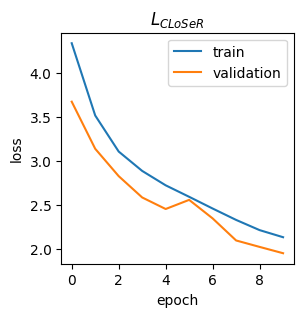

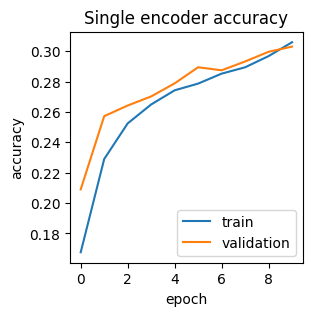

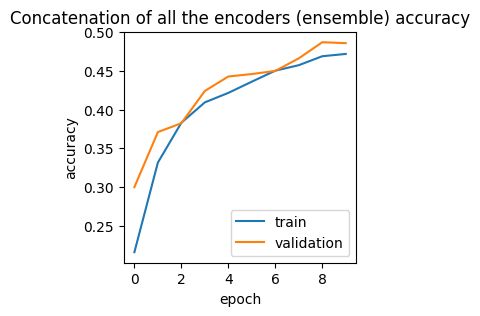

In [13]:
plt.figure(figsize=(3,3))
plt.title(r"$L_{CLoSeR}$")
plt.plot(history.history[model.name + "_embedding_pull"], label='train')
plt.plot(history.history["val_" + model.name + "_embedding_pull"], label='validation')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.figure(figsize=(3,3))
plt.title("Single encoder accuracy")
plt.plot(history.history[model.name + "_logits_accuracy"], label='train')
plt.plot(history.history["val_" + model.name + "_logits_accuracy"], label='validation')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.figure(figsize=(3,3))
plt.title("Concatenation of all the encoders (ensemble) accuracy")
plt.plot(history.history[model.name + "_ensemble_logits_accuracy"], label='train')
plt.plot(history.history["val_" + model.name + "_ensemble_logits_accuracy"], label='validation')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

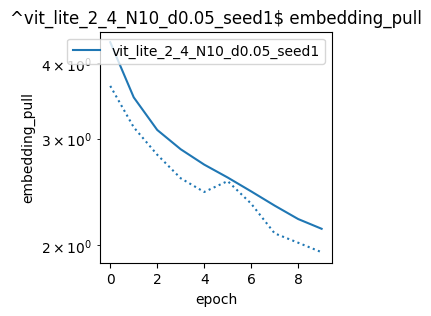

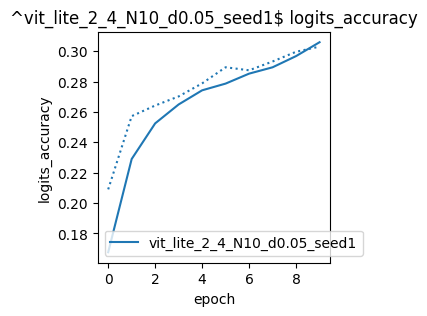

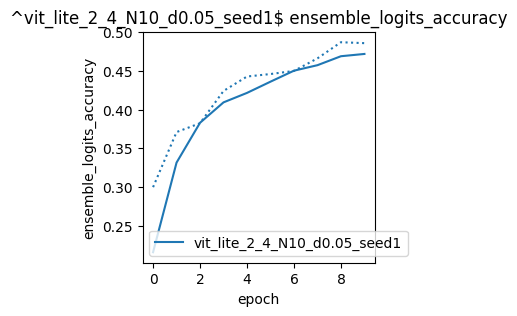

In [14]:
# If we saved our model, we can also plot multiple curves at the same at time
if save:
    from utils.figure_utils import plot_history
    plot_history("^" + model_name + "$",                                  # a regex of all the models you want to plot
                 MODULE,
                 figsize=(3,3),
                 plot_train=True,
                 plot_val=True,
                 window=1,                                                # smoothing window
                 keys_f=lambda n: 'embedding_pull' in n or 'acc' in n     # a function deciding what loss and metric keys to plot
                )

# Evaluate
After training you can evaluate your model. You can also use the evaluate.py script.

In [15]:
dataset_split = MODULE.get_class_from_data(dataset_name)(**deepcopy(data_kwargs), split=True)

splitting randomly


In [16]:
res = MODULE.evaluate(model, save_results=save, dataset=dataset_split, 
                      CS=[0],         # erase or change to different CS to use the validation to choose the right regularization
                      linear=True,    # whether or not to evaluate the embedding-concatenation ensemble
                      ensemble=True,  # whether or not to evaluate individual encoders and some ensembling methods
                      override=False, # whether or not to override and rerun if it's already saved
                      inp=False       # whether or not to evaluate a linear head on the *input*
                     )

getting embedding...
train...	done!
test...	done!
validation...	done!
running logistic
classify shape: x_train.shape=(45000, 256, 10), y_train.shape=(45000,)
C=0
classify shape: x_train.shape=(45000, 256, 10), y_train.shape=(45000,)


/home/projects/schneidmann/royu/miniconda3/envs/tf-gpu-cuda-11-8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train acc: 0.63600; Test acc: 0.52800


/home/projects/schneidmann/royu/miniconda3/envs/tf-gpu-cuda-11-8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train acc: 0.63600; Test acc: 0.53490; Val score: 0.52800
saved as vision/models/vit_lite_2_4_N10_d0.05_seed1/classification_eval.json
running ensemble
classify shape: x=(45000, 256, 10), y=(45000,)
C=0


0it [00:00, ?it/s]/home/projects/schneidmann/royu/miniconda3/envs/tf-gpu-cuda-11-8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
1it [00:03,  3.57s/it]/home/projects/schneidmann/royu/miniconda3/envs/tf-gpu-cuda-11-8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to t

ArgmaxMeanProb Train acc: 0.52160; Val acc: 0.47580; Test acc: 0.49500
saved as vision/models/vit_lite_2_4_N10_d0.05_seed1/classification_eval.json


In [17]:
print(json.dumps(res, indent=4))

{
    "logistic": [
        0.636,
        0.528,
        0.5349
    ],
    "pathway0_linear": [
        0.36573333333333335,
        0.3336,
        0.3445
    ],
    "pathway1_linear": [
        0.3957111111111111,
        0.3838,
        0.3706
    ],
    "pathway2_linear": [
        0.377,
        0.3522,
        0.3527
    ],
    "pathway3_linear": [
        0.35744444444444445,
        0.3396,
        0.336
    ],
    "pathway4_linear": [
        0.3907555555555556,
        0.3728,
        0.3652
    ],
    "pathway5_linear": [
        0.3770222222222222,
        0.3558,
        0.3577
    ],
    "pathway6_linear": [
        0.35613333333333336,
        0.3356,
        0.3342
    ],
    "pathway7_linear": [
        0.4139111111111111,
        0.3792,
        0.4004
    ],
    "pathway8_linear": [
        0.3423111111111111,
        0.3118,
        0.3292
    ],
    "pathway9_linear": [
        0.4119777777777778,
        0.3904,
        0.3883
    ],
    "pathways_mean_linear": [